# Official False Low Clouds Index
* SST (NOAA)
* air temp and moisture (GFS)
* data repackaged into more efficient netcdf files
* netcdf files are read for the FLC index

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import datetime
import os

time = "00z"

root = "/home/jturner/false_low_clouds_2023/Model/Time_Lapse/time_"+time+"/"

#ftime = "03z"
#root = "/home/jturner/false_low_clouds_2023/Model/Forecast/time_"+time+"_"+ftime+"/"

# Run analysis of processed data

In [2]:
date = '20220522'

sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"
#sst_file = root+date+"/oisst-avhrr-v02r01."+date+"_preliminary.nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

In [3]:
t = xr.open_dataset(root+date+'/t_'+date+'.nc')
q = xr.open_dataset(root+date+'/q_'+date+'.nc')

In [4]:
t

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] ...
Data variables:
    t           (latitude, longitude) float32 ...

Region for analysis:

In [5]:
#--- Northeast US
# min_lon = -83
# min_lat = 26
# max_lon = -51
# max_lat = 50

#--- Oaxaca
# min_lon = -109
# min_lat = 10
# max_lon = -81
# max_lat = 24

#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [6]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))
t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))
q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

In [7]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

Normalization through a pre-defined range for T and q. Intention is to have consistency in FLC index values. 

In [8]:
# bottom_lim = -4

# diff_np = np.asarray(diff).copy()
# under_zero = diff_np < bottom_lim
# diff_np[under_zero] = bottom_lim

In [9]:
# top_T = 4

# diff_norm = diff_np/(top_T - bottom_lim)

In [10]:
# top_q = 0.016
# bottom_q = 0.000
# q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

Normalization through the full T and q range in the dataset.

In [11]:
diff_np = np.asarray(diff).copy()
diff_norm = diff_np/(np.nanmax(diff_np) - np.nanmin(diff_np))

q_norm = (q.q[0:begin,0:end].values)/(np.nanmax(q.q[0:begin,0:end].values) - np.nanmin(q.q[0:begin,0:end].values))

In [12]:
flc_index = diff_norm*q_norm

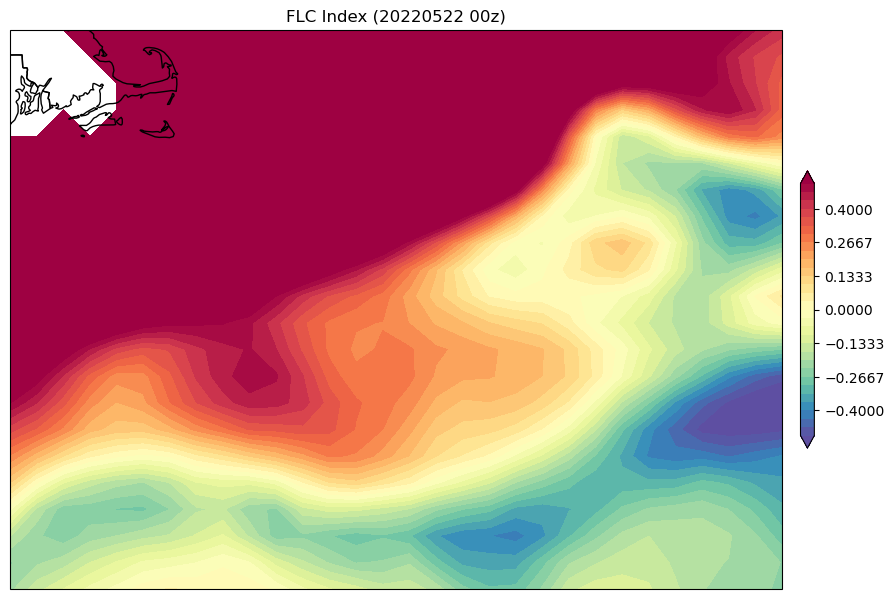

In [13]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 31)

c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index ('+date+' '+ time+')')
clb.set_label('')

#ax.coastlines(resolution='110m')
#ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

#plt.savefig('/Users/jesseturner/Downloads/flc_index_'+date+'.png', dpi=300)

## Bulk loading pre-made data

In [14]:
def FLC_warn_xarray(date):
    
    sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"
    sst_ds = xr.open_dataset(sst_file)
    sst_ds =  sst_ds.squeeze()
    sst_ds.sst.values = sst_ds.sst.values+273.15
    
    t = xr.open_dataset(root+date+'/t_'+date+'.nc')
    q = xr.open_dataset(root+date+'/q_'+date+'.nc')
    
#---Region for analysis
#     min_lon = -126 + 360
#     min_lat = 24.5
#     max_lon = -64 + 360
#     max_lat = 49.5
  
#---Commented out for global analysis
    sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))
    t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))
    q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

    begin = sst_ds.sst.shape[0]
    end = sst_ds.sst.shape[1]

    dims = t.t[0:begin,0:end]

    diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

    bottom_lim = -4

    diff_np = np.asarray(diff).copy()
    under_zero = diff_np < bottom_lim
    diff_np[under_zero] = bottom_lim

    top_T = 4

    diff_norm = diff_np/(top_T - bottom_lim)

    top_q = 0.016
    bottom_q = 0.000
    q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
    q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

    flc_index = diff_norm*q_norm

    #---Building the xarray dataset
    
    row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

    ds = xr.Dataset(
        data_vars=dict(
            flc_index=(["x","y"], flc_index)
        ),
        coords=dict(
            latitude=(["x","y"], row_meshgrid),
            longitude=(["x","y"], col_meshgrid),
        ),
        attrs=dict(description="FLC index in the designated region"),
    )
    
    ds = ds.expand_dims(dim={"time": 1})
    
    return ds

Add the datetimes in here, set to the year in question: 

In [15]:
year = '2022'

In [16]:
FLC_3d_xarray = []
dates = []

for filename in os.listdir(root):
    #print(filename)
    if (filename[0:4] == year): 
        FLC_3d_xarray.append(FLC_warn_xarray(filename))
        
        dates.append(datetime.datetime(int(filename[0:4]), int(filename[4:6]), int(filename[6:8])))
    

In [17]:
da_concat = xr.concat(FLC_3d_xarray, pd.Index(dates, name='time'))

Positive FLC index: Setting all negative FLC index to zero

In [18]:
da_concat = da_concat.where(da_concat.flc_index > 0, 0)

Summing the total FLC index

In [19]:
tot = da_concat.sum(dim='time')

In [20]:
flc_above = tot.flc_index.where(tot.flc_index > 0.15)

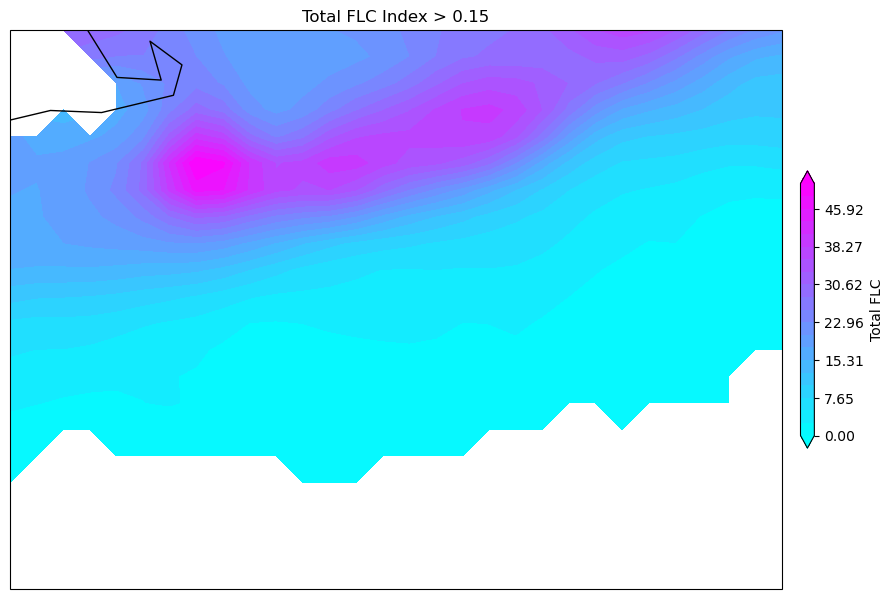

In [21]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0, np.amax(flc_above), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.15')
clb.set_label('Total FLC')

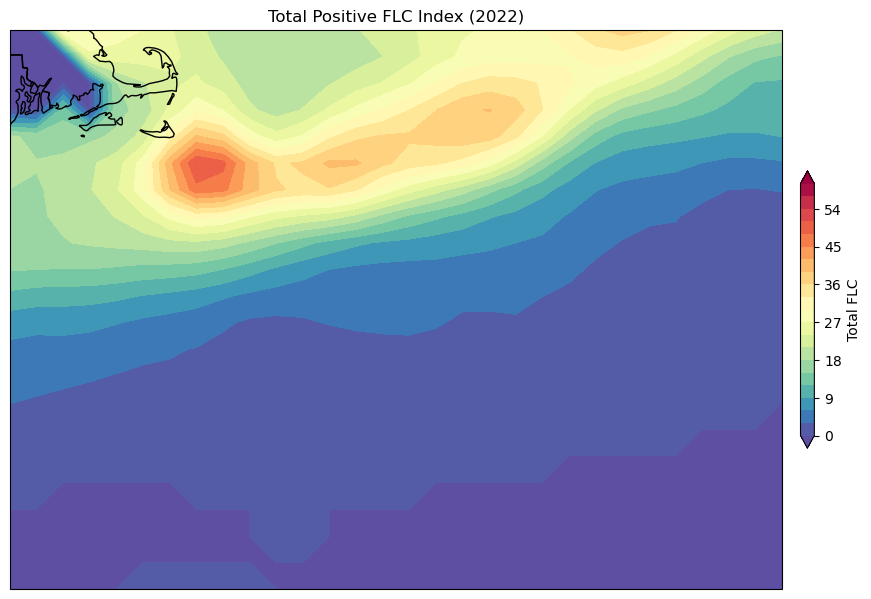

In [22]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---normal settings
# cmap = plt.cm.Spectral_r
# levels = np.linspace(-np.amax(tot.flc_index), np.amax(tot.flc_index), 35)

#---Positive FLC index (negative FLC indexes are removed)
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 60, 21)

c=ax.contourf(tot.longitude[0,:], tot.latitude[:,0], tot.flc_index, cmap=cmap, levels=levels, extend='both')

clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total Positive FLC Index ('+year+')')
clb.set_label('Total FLC')

#ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

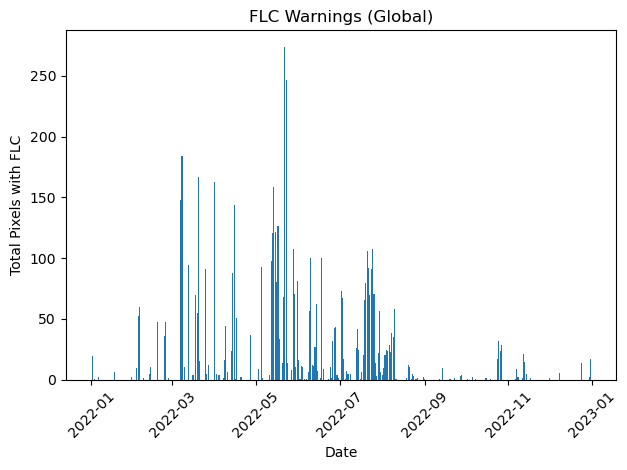

In [23]:
flc_above = []
da_tot_area = []
flc_above = da_concat.flc_index.where(da_concat.flc_index > 0.1)
da_tot_area = flc_above.sum(dim='x').sum(dim='y')

plt.bar(da_tot_area['time'], da_tot_area)

# add labels and title
plt.xlabel('Date')
plt.ylabel('Total Pixels with FLC')
plt.title('FLC Warnings (Global)')
plt.xticks(rotation=45)

plt.tight_layout()

In [24]:
da_tot_area[da_tot_area == da_tot_area.max()]

<xarray.DataArray 'flc_index' (time: 1)>
array([273.7386], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-05-22

Creating monthly composites of the FLCI data: 

In [25]:
da_concat = da_concat.sortby('time')

In [26]:
month_idxs=da_concat.groupby('time.month').groups
jan_idxs=month_idxs[1]
da_jan=da_concat.isel(time=jan_idxs)

In [27]:
da_jan

<xarray.Dataset>
Dimensions:    (time: 31, x: 22, y: 30)
Coordinates:
    latitude   (x, y) float64 37.0 37.0 37.0 37.0 ... 42.25 42.25 42.25 42.25
    longitude  (x, y) float64 288.5 288.8 289.0 289.2 ... 295.2 295.5 295.8
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-01-31
Dimensions without coordinates: x, y
Data variables:
    flc_index  (time, x, y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  FLC index in the designated region

In [28]:
month_length = da_concat.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 365)>
array([31, 31, 31, ..., 31, 31, 31])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31

In [29]:
ds_seasons = da_concat.groupby("time.season").sum(dim="time")

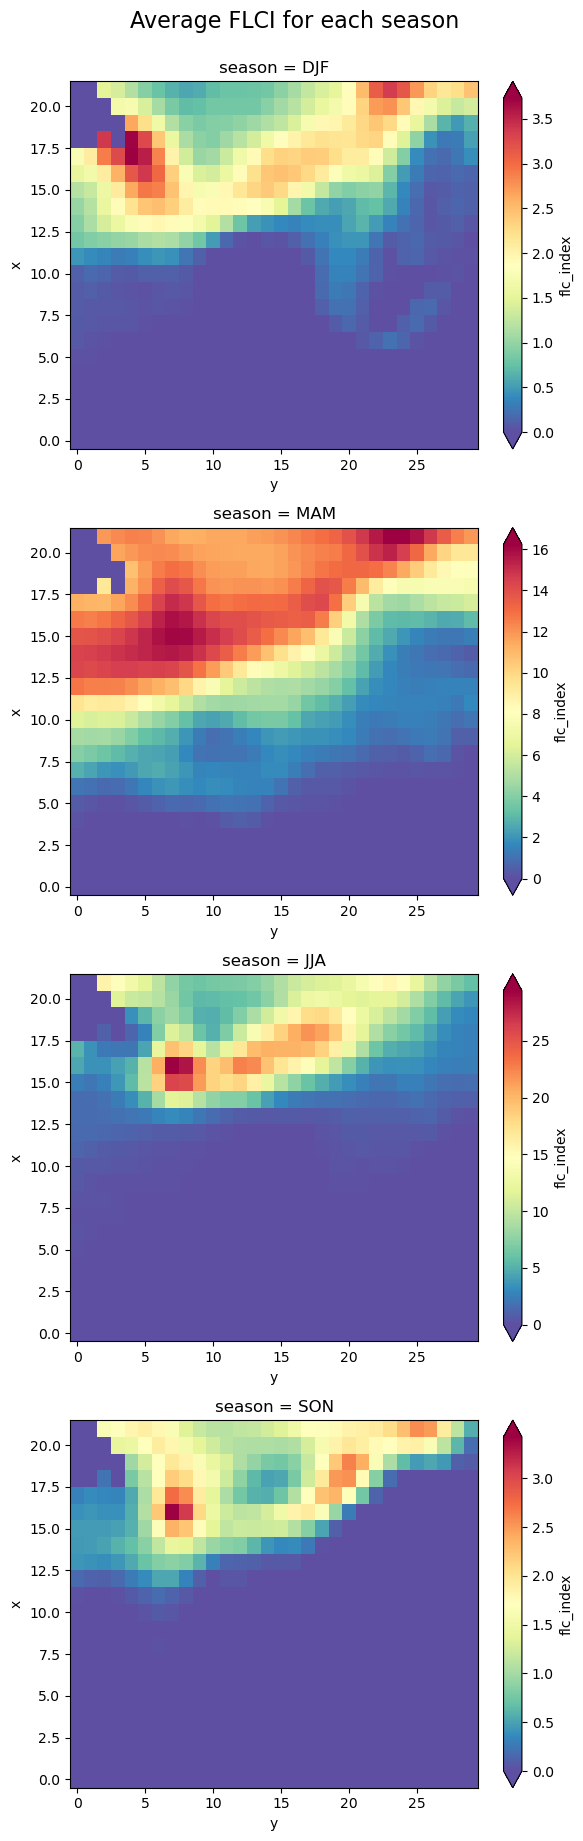

In [32]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 18))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    ds_seasons["flc_index"].sel(season=season).plot.pcolormesh(
        ax=axes[i],
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    
plt.tight_layout()

fig.suptitle("Average FLCI for each season", fontsize=16, y=1.02)
plt.savefig('average_FLCI_season.png', bbox_inches='tight')